# Notebook pour l'évaluation du corpus

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy, stanza
import langid
import os
import jupyter_black
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
jupyter_black.load()

## Chargement et analyse des données

In [3]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    Charge un fichier CSV et le retourne sous forme de DataFrame

    Parameters:
    filepath (str): Le chemin du fichier CSV à charger

    Returns:
    pd.DataFrame: Le DataFrame contenant les données du fichier CSV
    """
    return pd.read_csv(filepath)


def analyze_language_distribution(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la distribution des langues dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La distribution des langues
    """
    return data["Label"].value_counts()

In [4]:
data = load_data("../../data/csv/data.csv")
print(analyze_language_distribution(data))

Label
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
ar    548
Name: count, dtype: int64


Chaque ligne montre une langue représentée par son code (par exemple, "en" pour l'anglais, "ru" pour le russe, etc.) suivi du nombre de ligne en cette langue présents dans le corpus. Voici une description plus détaillée de ces résultats :

Ayant limité le nombre maximum à 550, la majorité des langues ont ce nombre de ligne/texte. Cependant, il y a l'arabe qui compte 548 lignes/textes.


In [5]:
def analyze_text_length(data: pd.DataFrame) -> pd.Series:
    """
    Analyse la longueur des textes dans le DataFrame

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: Les statistiques descriptives de la longueur des textes
    """
    data["Text_Length"] = data["Text"].apply(len)
    return data["Text_Length"].describe()


def plot_distributions(data: pd.DataFrame) -> None:
    """
    Affiche les distributions des langues et de la longueur des textes

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à afficher
    """
    # Appliquer le style de fond blanc
    sns.set_style("white")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(data=data, y="Label", order=data["Label"].value_counts().index)
    plt.title("Distribution des langues")
    plt.xlabel("Nombre de textes")
    plt.ylabel("Langue")

    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x="Text_Length", bins=30)
    plt.title("Distribution de la longueur des textes")
    plt.xlabel("Longueur du texte")
    plt.ylabel("Fréquence")

    plt.show()

count    4948.000000
mean      221.124697
std       220.553596
min         3.000000
25%        96.000000
50%       168.000000
75%       272.000000
max      3558.000000
Name: Text_Length, dtype: float64


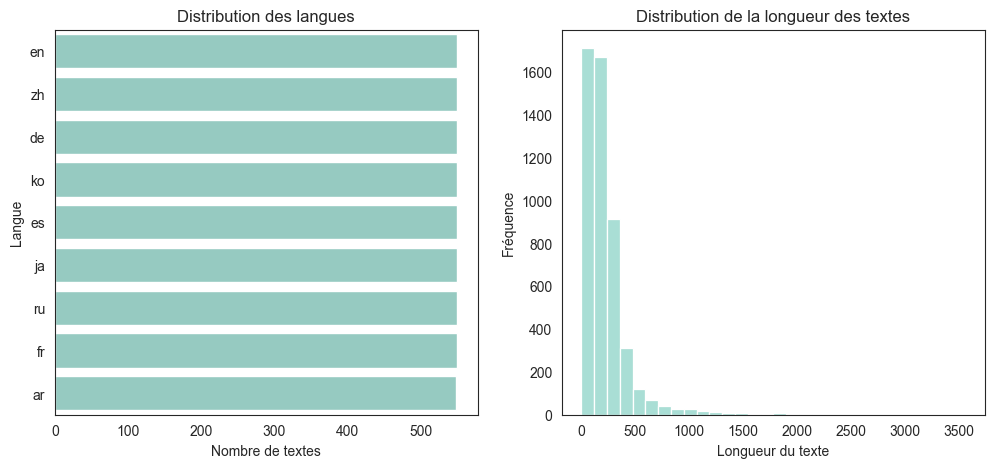

In [6]:
print(analyze_text_length(data))
plot_distributions(data)

### Analyse des Statistiques de Longueur des Textes

Voici un résumé correct des statistiques que vous avez fournies, illustrées sous forme de description textuelle pour mieux comprendre les implications :

- **Count**: 4948 textes ont été analysés, donnant une bonne taille d'échantillon pour des analyses statistiques robustes.
- **Mean**: La longueur moyenne des textes est de 221.12 caractères. Cela indique une tendance vers des textes modérément courts, ce qui est normal étant donné que pour chaque ligne il y a seulement jusqu'à 2 phrases maximum.
- **Std (Standard Deviation)**: L'écart-type est de 220.55, ce qui suggère une variation très considérable dans la longueur des textes, indiquant une distribution large.
- **Min**: Le texte le plus court fait seulement 3 caractères, ce qui pourrait être insuffisant pour certaines analyses linguistiques ou de traitement de texte.
- **25% (1st Quartile)**: 25% des textes ont 96 caractères ou moins.
- **50% (Median)**: La médiane est à 168 caractères, ce qui confirme que la moitié des textes sont assez courts.
- **75% (3rd Quartile)**: 75% des textes ont 272 caractères ou moins.
- **Max**: Le texte le plus long a 3558 caractères, montrant qu'il y a des cas où les textes sont significativement plus longs.

### Interprétation Visuelle (Graphique)
1. **Distribution des langues** : Le graphique montre que l'anglais (en) est la langue avec le plus grand nombre de textes, suivi par le chinois (zh) et l'allemand (de). Cela peut indiquer une concentration de l'échantillon sur certaines langues majeures.
2. **Distribution de la longueur des textes** : La plupart des textes sont concentrés dans les premières barres du graphique, avec une longueur de moins de 500 caractères, ce qui correspond à la description de la médiane et du premier quartile.


In [7]:
def augment_underrepresented_labels(
    data: pd.DataFrame, label_col: str, text_col: str, threshold: int
) -> pd.DataFrame:
    """
    Augmente les étiquettes sous-représentées dans un DataFrame en utilisant RandomOverSampler.

    Parameters:
    - data (pd.DataFrame): Le DataFrame contenant les colonnes de texte et d'étiquettes.
    - label_col (str): Le nom de la colonne contenant les étiquettes.
    - text_col (str): Le nom de la colonne contenant les textes.
    - threshold (int): Le seuil minimal du nombre d'échantillons par étiquette.

    Returns:
    - pd.DataFrame: Le DataFrame augmenté.
    """
    # Obtenir le nombre d'échantillons par étiquette
    label_counts = data[label_col].value_counts()

    # Créer une stratégie de sur-échantillonnage pour les étiquettes sous-représentées
    sampling_strategy = {
        label: threshold for label, count in label_counts.items() if count < threshold
    }

    # Vérifier si des étiquettes sous-représentées existent
    if not sampling_strategy:
        print("Aucune étiquette sous-représentée trouvée.")
        return data

    # Isoler les textes et les étiquettes
    X = data[[text_col]]
    y = data[label_col]

    # Utiliser RandomOverSampler pour augmenter les étiquettes sous-représentées
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Créer un nouveau DataFrame avec les données augmentées
    augmented_data = pd.DataFrame(
        {label_col: y_resampled, text_col: X_resampled[text_col]}
    )

    return augmented_data

Label
ar    550
en    550
zh    550
de    550
ko    550
es    550
ja    550
ru    550
fr    550
Name: count, dtype: int64


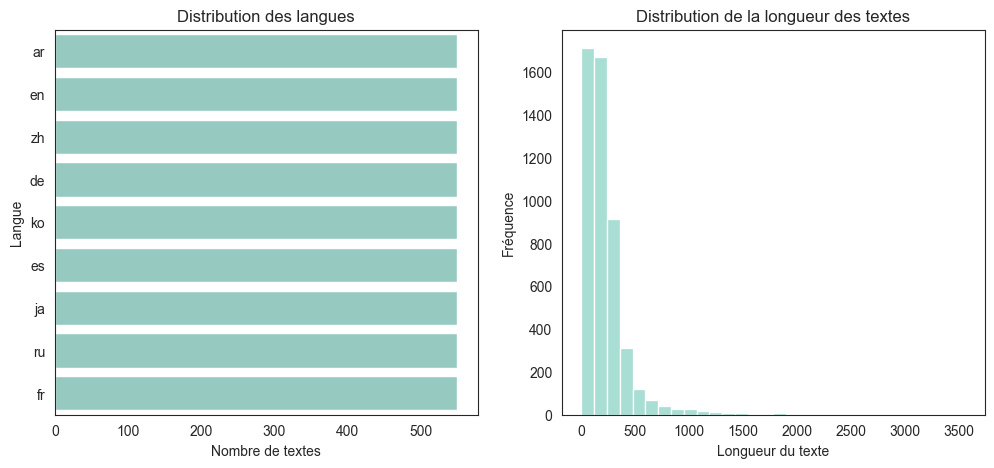

In [8]:
# Utiliser la fonction pour augmenter les étiquettes ayant moins de 550 échantillons
augmented_data = augment_underrepresented_labels(data, "Label", "Text", 550)

augmented_data.to_csv("../../data/csv/augmented_data.csv", index=False)

# Vérifier la nouvelle distribution des étiquettes
print(augmented_data["Label"].value_counts())

analyze_text_length(augmented_data)

plot_distributions(augmented_data)

In [9]:
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

nlp_ar = stanza.Pipeline(lang="ar")  # Arabic


def tokenize(text: str, lang: str) -> list:
    """
    Permet de tokeniser un texte en fonction de la langue

    Parameters:
    text (str): le texte à tokeniser
    lang (str): la langue du texte

    Returns:
    list: une liste de tokens
    """
    if lang == "ar":
        doc = nlp_ar(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [token.text for token in doc]


def vocabulary_diversity(data: pd.DataFrame) -> pd.Series:
    """
    Calcule la diversité du vocabulaire pour chaque langue

    Parameters:
    data (pd.DataFrame): Le DataFrame contenant les données à analyser

    Returns:
    pd.Series: La diversité du vocabulaire pour chaque langue
    """
    data["Tokens"] = data.apply(lambda row: tokenize(row["Text"], row["Label"]), axis=1)
    data["Vocab_Size"] = data["Tokens"].apply(lambda x: len(set(x)))
    return data.groupby("Label")["Vocab_Size"].mean()

2024-05-11 11:07:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-11 11:07:17 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
INFO:stanza:Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-11 11:07:18 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-11 11:07:18 INFO: Using device: cpu
INFO:stanza:Using device: cpu
2024-05-11 11:07:18 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2024-05-11 11:07:19 INFO: Loading: mwt
INFO:stanza:Loading: mwt
20

In [10]:
vocab_diversity = vocabulary_diversity(augmented_data)
print(vocab_diversity)

Label
ar    74.383636
de    25.018182
en    38.920000
es    36.992727
fr    38.372727
ja    40.641818
ko    25.650909
ru    28.961818
zh    36.001818
Name: Vocab_Size, dtype: float64


# Interprétation des Résultats précédents

### Analyse des Résultats
- **Arabe (ar)**: Avec une moyenne de 74.38, l'arabe montre la diversité lexicale la plus élevée parmi les langues analysées. Cela pourrait s'expliquer par la structure morphologique riche de la langue, où un nombre relativement élevé de formes de mots peut être généré à partir de racines verbales courtes.
- **Allemand (de)** et **Coréen (ko)**: Ces langues présentent les niveaux les plus faibles de diversité lexicale avec des moyennes de 25.02 et 25.65, respectivement. Cela peut indiquer un usage de vocabulaire plus standardisé ou une uniformité dans les types de textes sélectionnés pour ces langues dans le corpus.
- **Anglais (en)**, **Espagnol (es)**, **Français (fr)**, et **Chinois (zh)**: Ces langues affichent des valeurs proches les unes des autres, variant de 36.00 à 38.92, indiquant une diversité modérée. Cela suggère que les textes dans ces langues utilisent un éventail raisonnable de vocabulaire sans atteindre les extrêmes.
- **Japonais (ja)**: Affiche une valeur de 40.64, positionnant le japonais parmi les langues avec une diversité relativement élevée. Cela pourrait être attribué à l'utilisation combinée de caractères Kanji, Hiragana et Katakana, qui augmentent le nombre de mots uniques identifiés.
- **Russe (ru)**: Montre une diversité modeste avec une moyenne de 28.96. Le russe, étant une langue à inflexion riche, cette mesure peut refléter une variété modérée de formes morphologiques utilisées dans les textes.

### Implications pour la Détection de la Langue
- **Entraînement des Modèles** : La diversité lexicale élevée dans certaines langues peut poser des défis pour les modèles de traitement du langage naturel en termes de prédiction précise de la langue, surtout dans les corpus de textes courts.
- **Prétraitement et Normalisation** : Les techniques de lemmatisation et de normalisation pourraient être essentielles pour les langues avec une grande diversité lexicale pour réduire la complexité et améliorer la performance des modèles.
- **Équilibrage du Corpus** : Les résultats indiquent la nécessité d'équilibrer le corpus non seulement en termes de quantité de textes par langue mais également en termes de diversité lexicale pour minimiser les biais vers les langues avec une diversité naturellement plus élevée ou plus faible.

### Conclusion
Ces résultats soulignent l'importance d'une analyse détaillée des propriétés linguistiques spécifiques à chaque langue pour améliorer les stratégies de prétraitement et d'entraînement des modèles dans le cadre d'un système de détection de la langue efficace, en particulier pour un corpus comprenant des textes courts et multilingues.

In [11]:
def split_train_dev_test(
    csv_path: str,
    folder_csv: str,
    label_column: str,
    train_size: float = 0.7,
    dev_size: float = 0.15,
    random_state: int = 42,
) -> None:
    """
    Cette fonction prend un fichier CSV d'entrée, le divise en ensembles d'entraînement, de développement (dev),
    et de test, et équilibre les classes dans chaque ensemble.

    Parameters:
    - csv_path (str): Le chemin du fichier CSV à charger
    - folder_csv (str): Le dossier de sortie pour les fichiers CSV
    - label_column (str): Le nom de la colonne contenant les étiquettes
    - train_size (float): La proportion de l'ensemble d'entraînement (ex: 0.7 pour 70%)
    - dev_size (float): La proportion de l'ensemble de développement
    - random_state (int): Le générateur de nombres aléatoires pour la reproductibilité

    Returns:
    - None
    """
    # Charger les données depuis le fichier CSV
    data = pd.read_csv(csv_path)

    # Calculer la proportion de l'ensemble de test
    test_size = 1.0 - train_size

    # Diviser les données en ensembles d'entraînement et (dev + test)
    df_train, df_dev_test = train_test_split(
        data, train_size=train_size, random_state=random_state
    )

    # Calculer la proportion de l'ensemble dev dans les données restantes
    dev_proportion = dev_size / (1.0 - train_size)

    # Diviser l'ensemble (dev + test) en ensembles de développement et de test
    df_dev, df_test = train_test_split(
        df_dev_test, train_size=dev_proportion, random_state=random_state
    )

    # Identifier la classe majoritaire dans l'ensemble d'entraînement
    majority_class = df_train[label_column].mode()[0]

    # Fonction d'équilibrage des classes
    def balance_classes(df, majority_class):
        balanced_df = pd.DataFrame()
        for label in df[label_column].unique():
            class_subset = df[df[label_column] == label]
            balanced_subset = resample(
                class_subset,
                replace=True,
                n_samples=len(df[df[label_column] == majority_class]),
                random_state=random_state,
            )
            balanced_df = pd.concat([balanced_df, balanced_subset])
        return balanced_df

    # Équilibrer les classes pour les ensembles d'entraînement, de développement, et de test
    balanced_train = balance_classes(df_train, majority_class)
    balanced_dev = balance_classes(df_dev, majority_class)
    balanced_test = balance_classes(df_test, majority_class)

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(folder_csv, exist_ok=True)

    # Exporter les ensembles d'entraînement, de développement, et de test en fichiers CSV
    balanced_train.to_csv(
        os.path.join(folder_csv, "data_train.csv"), index=False, encoding="utf-8"
    )
    balanced_dev.to_csv(
        os.path.join(folder_csv, "data_dev.csv"), index=False, encoding="utf-8"
    )
    balanced_test.to_csv(
        os.path.join(folder_csv, "data_test.csv"), index=False, encoding="utf-8"
    )

In [12]:
def detect_language(text: str) -> str:
    """
    Detecte la langue d'un texte

    Parameters:
    text (str): le texte à analyser

    Returns:
    str: la langue du texte
    """
    lang, _ = langid.classify(text)
    return lang


def plot_confusion_matrix(data: pd.DataFrame) -> plt.Figure:
    """
    Matrice de confusion pour la détection de la langue des textes.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    plt.Figure: l'objet Figure contenant le graphique
    """
    true_labels = data["Label"].tolist()
    predictions = data["Text"].apply(detect_language)
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    return fig

In [13]:
def build_and_test_model(train_csv: str, test_csv: str) -> None:
    """
    Construit un modèle de classification de texte et l'évalue en utilisant des fichiers CSV d'entraînement et de test séparés.

    Parameters:
    train_csv (str): Chemin vers le fichier CSV d'entraînement.
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données d'entraînement et de test
    train_data = pd.read_csv(train_csv)
    test_data = pd.read_csv(test_csv)

    # Remplacement des valeurs NaN par des chaînes vides
    train_data["Text"] = train_data["Text"].fillna("")
    test_data["Text"] = test_data["Text"].fillna("")

    # Vectorisation des textes
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data["Text"])
    y_train = train_data["Label"]
    X_test = vectorizer.transform(test_data["Text"])
    y_test = test_data["Label"]

    # Construction et entraînement du modèle
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Rapport de classification
    print(classification_report(y_test, y_pred))

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        confusion_matrix(y_test, y_pred, normalize="true"),
        annot=True,
        fmt=".2%",
        xticklabels=sorted(set(y_test)),
        yticklabels=sorted(set(y_test)),
        cmap="OrRd",
    )
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")

    save_path = "../../resultats/confusion_matrix.png"
    plt.savefig(save_path, facecolor="w", bbox_inches="tight")

    plt.show()

              precision    recall  f1-score   support

          ar       0.46      1.00      0.63        73
          de       0.90      0.99      0.94        73
          en       0.89      1.00      0.94        73
          es       0.94      1.00      0.97        73
          fr       0.99      1.00      0.99        73
          ja       0.84      0.37      0.51        73
          ko       1.00      0.92      0.96        73
          ru       0.96      0.96      0.96        73
          zh       0.86      0.16      0.28        73

    accuracy                           0.82       657
   macro avg       0.87      0.82      0.80       657
weighted avg       0.87      0.82      0.80       657



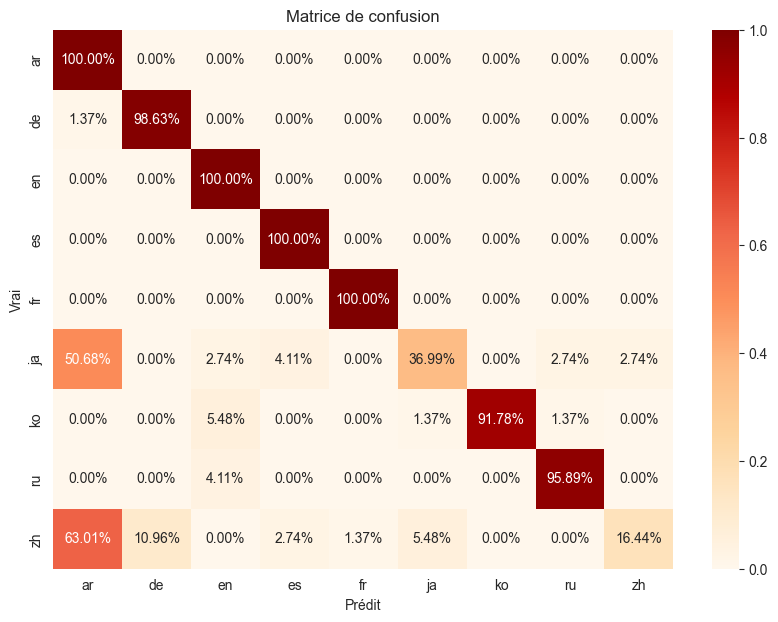

In [15]:
split_train_dev_test(
    csv_path="../../data/csv/augmented_data.csv",
    folder_csv="../../data/csv/",
    label_column="Label",
    train_size=0.7,
    dev_size=0.15,
    random_state=42,
)

train_csv = "../../data/csv/data_train.csv"
test_csv = "../../data/csv/data_test.csv"

build_and_test_model(train_csv, test_csv)

### Analyse de la Matrice de Confusion 1

- **Performance Globale** : La matrice montre des intensités fortes sur la diagonale pour la plupart des langues, indiquant un taux élevé de prédictions correctes. Cependant, le japonais (`ja`) et le chinois (`zh`) présentent des teintes significativement plus claires, suggérant des erreurs de classification fréquentes.
- **Arabe (`ar`)** : Affiche un taux élevé de vrais positifs (100%), indiquant une excellente distinction de cette langue par rapport aux autres.
- **Allemand (`de`)** : Taux de prédiction correct très élevé (98,63%) avec une confusion minimale, indiquant une classification efficace.
- **Anglais (`en`), Espagnol (`es`), Français (`fr`)** : Ces langues montrent des taux de prédiction parfaits (100%), ce qui démontre que le modèle les distingue très bien.
- **Japonais (`ja`)** : Performance médiocre avec seulement 36,99% de prédictions correctes, indiquant des confusions significatives avec d'autres langues telles que l'arabe (50,68%) et le chinois, le russe, l'anglais (2,74%) ainsi que l'espagnol (4,11%).
- **Coréen (`ko`)** : Bon taux de prédiction (91,78%), avec quelques classifications erronées mineures (anglais (5,48%), le russe et le japonais (1,37%)).
- **Russe (`ru`)** : Haute précision (95,89%) avec peu d'erreurs, montrant une forte performance du modèle pour cette langue.
- **Chinois (`zh`)** : Taux de vrais positifs très faible (16,44%), indiquant de sérieux problèmes de classification, notamment avec l'arabe (63,01%), l'allemand (10,96%) le japonais (5,48%), l'espagnol (2,74%) et le français (1,37%).

### Analyse des Scores de Classification

- **Précision** : Des langues comme le russe (`ru`), le français (`fr`), et l'espagnol (`es`) montrent une très haute précision, suggérant que les prédictions pour ces langues sont fiables. Cependant, l'arabe (`ar`) a une précision faible (0,46), reflétant de fréquents faux positifs, possiblement dû à des caractéristiques partagées avec d'autres langues.
  
- **Rappel** : Le rappel est parfait pour la plupart des langues sauf pour le japonais (`ja`) et le chinois (`zh`), qui présentent des valeurs significativement plus basses, indiquant que de nombreuses instances de ces langues sont mal classifiées comme d'autres langues.
  
- **Score F1** : Ce score est crucial pour comprendre l'équilibre entre la précision et le rappel. Le japonais (`ja`) et le chinois (`zh`) ont des scores F1 très bas, reflétant une performance globale médiocre et suggérant des domaines nécessitant une amélioration du modèle.

### Conclusion

Alors que le modèle de détection de langue est très performant pour des langues comme le russe, l'allemand, l'anglais, l'espagnol et le français, il présente des déficiences significatives avec le japonais et le chinois. Les faibles scores F1 pour ces langues indiquent des problèmes de classification qui nécessitent une attention particulière pour améliorer la précision et la fiabilité du modèle.

              precision    recall  f1-score   support

          ar       1.00      1.00      1.00        73
          de       1.00      0.97      0.99        73
          en       0.97      1.00      0.99        73
          es       0.95      0.99      0.97        73
          fr       1.00      0.95      0.97        73
          ja       0.99      1.00      0.99        73
          ko       1.00      1.00      1.00        73
          ru       1.00      1.00      1.00        73
          zh       0.99      0.99      0.99        73

    accuracy                           0.99       657
   macro avg       0.99      0.99      0.99       657
weighted avg       0.99      0.99      0.99       657



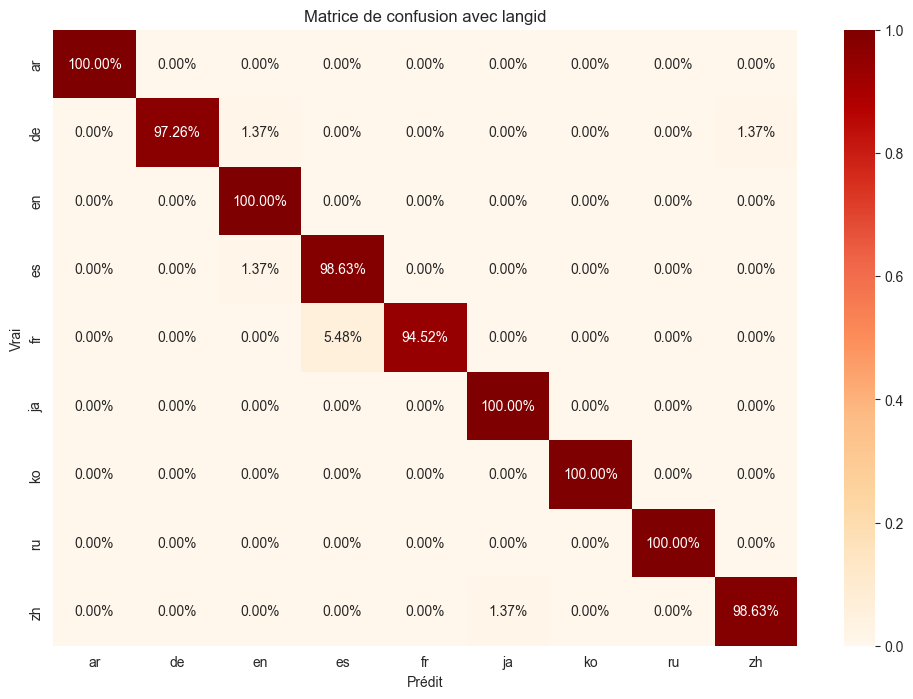

In [16]:
def build_and_test_model_with_langid(test_csv: str) -> None:
    """
    Construit un modèle de classification de texte utilisant langid pour la prédiction de la langue,
    en configurant langid pour détecter uniquement les langues présentes dans les étiquettes de données de test.

    Parameters:
    test_csv (str): Chemin vers le fichier CSV de test.
    """
    # Chargement des données de test
    test_data = pd.read_csv(test_csv)
    test_data["Text"] = test_data["Text"].fillna(
        ""
    )  # Remplacement des valeurs NaN par des chaînes vides

    # Extraire les langues uniques à partir des étiquettes
    languages = sorted(test_data["Label"].unique())
    langid.set_languages(
        languages
    )  # Configurer langid pour limiter la détection aux langues spécifiées

    # Prédiction des langues avec langid
    predictions = [langid.classify(text)[0] for text in test_data["Text"]]
    test_data["Predicted"] = predictions

    # Obtention des ensembles de labels uniques
    unique_labels = sorted(set(test_data["Label"]))
    unique_predictions = sorted(set(test_data["Predicted"]))

    # Union des labels et des prédictions pour couvrir toutes les possibilités
    all_langs = sorted(set(unique_labels + unique_predictions))

    print(
        classification_report(
            test_data["Label"],
            test_data["Predicted"],
            labels=all_langs,
            zero_division=0,
        )
    )

    # Création de la matrice de confusion
    cm = confusion_matrix(
        test_data["Label"], test_data["Predicted"], labels=all_langs, normalize="true"
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2%",
        cmap="OrRd",
        xticklabels=all_langs,
        yticklabels=all_langs,
    )
    plt.title("Matrice de confusion avec langid")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")

    save_path = "../../resultats/confusion_matrix_with_langid.png"
    plt.savefig(save_path, facecolor="w", bbox_inches="tight")

    plt.show()


build_and_test_model_with_langid(test_csv)

### Analyse de la Matrice de Confusion avec LangID

Cette matrice de confusion illustre des performances globalement parfaite pour la détection de la langue avec le modèle LangID, présentant des taux élevés de prédiction correcte pour toutes les langues :

- **Arabe (ar)** : Identification parfaite avec 100% de prédiction correcte, illustrant une excellente capacité du modèle à distinguer cette langue.
- **Allemand (de)** : Excellente performance avec 97.26% de prédiction correcte. Une légère confusion est observée avec l'anglais (1.37%) et le chinois (1.37%).
- **Anglais (en)** : Précision de prédiction parfaite à 100%, démontrant une robustesse du modèle pour identifier correctement l'anglais.
- **Espagnol (es)** : Très haute précision avec 98.63% de prédiction correcte, avec une infime confusion avec l'anglais (1.37%).
- **Français (fr)** : Très bonne performance avec 94.52% de prédiction correcte, avec une petite confusion avec l'espagnol (5.48%).
- **Japonais (ja)** : Identification parfaite avec 100% de prédiction correcte, montrant une amélioration significative dans la distinction du japonais par rapport aux données antérieures.
- **Coréen (ko)** : Identification parfaite avec 100% de prédiction correcte, indiquant une détection très précise du coréen.
- **Russe (ru)** : Comme le japonais et le coréen, le russe affiche une performance parfaite de 100% sans confusion avec d'autres langues.
- **Chinois (zh)** : Excellente prédiction à 98.63%, avec une très légère confusion avec le japonais (1.37%).

### Scores de Précision, Rappel et F1

- **Précision et Rappel** : La plupart des langues affichent des scores de précision et de rappel extrêmement élevés, souvent parfaits (1.00). L'allemand, le français et l'espagnol présentent des précisions légèrement inférieures mais toujours très élevées, indiquant une forte capacité de distinction des langues par le modèle.
- **Score F1** : Les scores F1 sont proches de la perfection pour toutes les langues, reflétant un excellent équilibre entre la précision et le rappel. Les scores F1 sont excellents même pour les langues avec de petites confusions, indiquant une performance globale robuste et fiable.

### Conclusion

L'analyse révèle l'efficacité remarquable du modèle LangID dans la détection précise de diverses langues, avec des performances exceptionnelles pour presque toutes les langues testées. Les rares cas de confusion sont très mineurs et n'affectent pas significativement l'efficacité globale du modèle.

La comparaison entre les deux matrices de confusion et leurs résultats associés montre un impact notable de l'intégration de la technologie LangID sur l'amélioration des performances de détection de langue. Voici une correction détaillée de l'analyse comparative :

### Première Matrice de Confusion (Sans LangID)
- **Performances Générales** : La première matrice montre une précision globale moyenne, avec des performances variables entre les langues. Le japonais (ja) et le chinois (zh) affichent des taux de rappel particulièrement faibles, soulignant des difficultés majeures dans leur classification correcte.
- **Problèmes Spécifiques** :
  - **Japonais (ja)** : Montre un faible taux de prédiction correcte, principalement confondu avec l'arabe et d'autres langues, ce qui révèle une grande confusion inter-langues.
  - **Chinois (zh)** : Présente un très faible taux de prédiction correcte, majoritairement confondu avec l'arabe, soulignant d'importants défis de classification.

### Deuxième Matrice de Confusion (Avec LangID)
- **Performances Générales** : Cette matrice illustre une nette amélioration avec une exactitude globale de 99%, signifiant une distinction nettement plus précise des langues.
- **Problèmes Spécifiques** :
  - **Allemand (de)** : Bien que présentant une légère confusion avec l'anglais et le chinois, montre une amélioration notable par rapport à la première matrice.
  - **Chinois (zh)** : Affiche une amélioration considérable avec un rappel proche de la perfection, démontrant une capacité accrue du modèle à distinguer le chinois correctement.

### Comparaison et Conclusion
- **Amélioration avec LangID** : L'introduction de LangID dans la deuxième matrice a nettement amélioré les performances, réduisant considérablement les confusions inter-langues et augmentant la précision et le rappel pour presque toutes les langues. Cette amélioration est particulièrement notable pour des langues précédemment problématiques comme le japonais et le chinois.
- **Implications pour le Traitement NLP** : L'utilisation d'outils comme LangID peut considérablement réduire les erreurs de classification de langue, ce qui est crucial pour des applications pratiques telles que la traduction automatique ou le filtrage de contenu.
- **Analyse pour l'Amélioration** : Bien que les performances soient déjà élevées, une analyse continue des erreurs restantes peut aider à affiner davantage les modèles ou les techniques de prétraitement pour cibler les confusions spécifiques qui subsistent.

Cette comparaison souligne la valeur ajoutée de l'intégration des technologies avancées dans les systèmes de traitement automatique des langues, montrant des gains significatifs en précision et en fiabilité.